In [ ]:
import os
from pathlib import Path


# Navigate to the project root directory (where .git is)
def find_git_root(path="."):
    path = Path(path).resolve()
    for parent in [path] + list(path.parents):
        if (parent / ".git").exists():
            return parent
    return path  # fallback if .git not found


project_root = find_git_root()
os.chdir(project_root)
print(f"Working directory set to: {project_root}")

Working directory set to: /Users/sherman/GitHub/ISYE-6740/Final Project/Workspace


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix
from sklearn.preprocessing import LabelEncoder

pd.set_option("display.max_columns", 50)

In [ ]:
transaction_data = pd.read_parquet(
    "data/processed/master_dataset.parquet",
    columns=["CustomerID", "ProductName", "CategoryName", "Class"],
)

cluster_data = pd.read_parquet("data/processed/clustered_customer_GMM.parquet")

display(transaction_data.head())
print(f"Transaction data shape: {transaction_data.shape}")

display(cluster_data.head())
print(f"Cluster data shape: {cluster_data.shape}")

,CustomerID,ProductName,CategoryName,Class
0,27039,Vaccum Bag 10x13,Confections,High
1,25011,Sardines,Grain,Low
2,94024,Crab - Imitation Flakes,Produce,Medium
3,73966,Smirnoff Green Apple Twist,Seafood,High
4,32653,Coffee - Dark Roast,Poultry,Low


Transaction data shape: (6758125, 4)


,CustomerID,cluster_label
0,1,2
1,2,2
2,3,2
3,4,2
4,5,2


Cluster data shape: (98759, 2)


In [ ]:
transaction_data["CustomerID"] = transaction_data["CustomerID"].astype(str)
cluster_data["CustomerID"] = cluster_data["CustomerID"].astype(str)

In [ ]:
df = pd.merge(
    transaction_data,
    cluster_data,
    on="CustomerID",
    how="left",
    validate="m:1",
)

df.head()

,CustomerID,ProductName,CategoryName,Class,cluster_label
0,27039,Vaccum Bag 10x13,Confections,High,1
1,25011,Sardines,Grain,Low,1
2,94024,Crab - Imitation Flakes,Produce,Medium,2
3,73966,Smirnoff Green Apple Twist,Seafood,High,2
4,32653,Coffee - Dark Roast,Poultry,Low,1


In [ ]:
# Store final models and matrices
cluster_models = {}
user_encoders = {}
item_encoders = {}
matrix_item_user = {}
matrix_user_item = {}

for cluster in df["cluster_label"].unique():
    # Filter data
    cluster_df = df[df["cluster_label"] == cluster].copy()

    # Encode users and items
    user_encoder = LabelEncoder()
    item_encoder = LabelEncoder()
    cluster_df["user_idx"] = user_encoder.fit_transform(cluster_df["CustomerID"])
    cluster_df["item_idx"] = item_encoder.fit_transform(cluster_df["ProductName"])
    cluster_df["interaction"] = 1

    # Build full interaction matrix
    grouped = (
        cluster_df.groupby(["user_idx", "item_idx"])["interaction"].sum().reset_index()
    )

    matrix = coo_matrix(
        (grouped["interaction"], (grouped["item_idx"], grouped["user_idx"]))
    ).tocsr()

    # Train ALS model
    model = AlternatingLeastSquares(
        factors=100,
        regularization=0.01,
        iterations=15,
    )
    model.fit(matrix)

    # Save model + encoders + matrices
    cluster_models[cluster] = model
    user_encoders[cluster] = user_encoder
    item_encoders[cluster] = item_encoder
    matrix_item_user[cluster] = matrix
    matrix_user_item[cluster] = matrix.T.tocsr()

    print(f"Model for cluster {cluster} trained with shape {matrix.shape}")

/Users/sherman/Downloads/jupyter/lib/python3.9/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 8 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

Model for cluster 1 trained with shape (452, 22463)


  0%|          | 0/15 [00:00<?, ?it/s]

Model for cluster 2 trained with shape (452, 47197)


  0%|          | 0/15 [00:00<?, ?it/s]

Model for cluster 3 trained with shape (452, 25301)


  0%|          | 0/15 [00:00<?, ?it/s]

Model for cluster 0 trained with shape (452, 3798)


# Top N Recommended Items per Cluster


In [ ]:
def get_top_items(model, item_encoder, top_n=10):
    # Total number of trained items
    n_items_trained = len(item_encoder.classes_)

    # Score each item by its total affinity across all users
    scores = model.item_factors[:n_items_trained] @ model.user_factors.T
    total_scores = scores.sum(axis=1)

    # Get top-N item indices
    top_items_idx = np.argsort(total_scores)[::-1][:top_n]

    # Map to actual product names
    return list(item_encoder.inverse_transform(top_items_idx))


top_items_per_cluster = {}
top_items_records = []

for cluster in cluster_models:
    top_items = get_top_items(
        cluster_models[cluster],
        item_encoders[cluster],
        top_n=30,
    )
    top_items_per_cluster[cluster] = top_items

    for rank, item in enumerate(top_items, start=1):
        top_items_records.append(
            {"Cluster": cluster, "Rank": rank, "ProductName": item}
        )

top_items_df = pd.DataFrame(top_items_records)
top_items_df.head()

,Cluster,Rank,ProductName
0,1,1,Sausage - Breakfast
1,1,2,Bouq All Italian - Primerba
2,1,3,"Beans - Kidney, Red Dry"
3,1,4,Soup V8 Roasted Red Pepper
4,1,5,Table Cloth 81x81 White


# Category Distribution of Recommendations


In [ ]:
# Create a mapping from ProductName to Class
product_to_class = (
    df[["ProductName", "Class"]]
    .drop_duplicates("ProductName")
    .set_index("ProductName")["Class"]
    .to_dict()
)

# Calculate Class counts for recommendations in each cluster
class_counts_per_cluster = {}

for cluster, recommended_items in top_items_per_cluster.items():
    class_counts = Counter()
    for item_name in recommended_items:
        item_class = product_to_class.get(item_name)
        if item_class:
            class_counts[item_class] += 1
        else:
            print(
                f"Warning: Class not found for recommended item '{item_name}' in cluster {cluster}"
            )
    class_counts_per_cluster[cluster] = dict(class_counts)

# Convert results to a DataFrame
class_dist_df = (
    pd.DataFrame.from_dict(class_counts_per_cluster, orient="index")
    .fillna(0)
    .astype(int)
    .rename_axis("cluster_label")
)

# Reorder columns
class_order = ["Low", "Medium", "High"]
for c in class_order:
    if c not in class_dist_df.columns:
        class_dist_df[c] = 0
class_dist_df = class_dist_df[class_order]
class_dist_df = class_dist_df.sort_index()

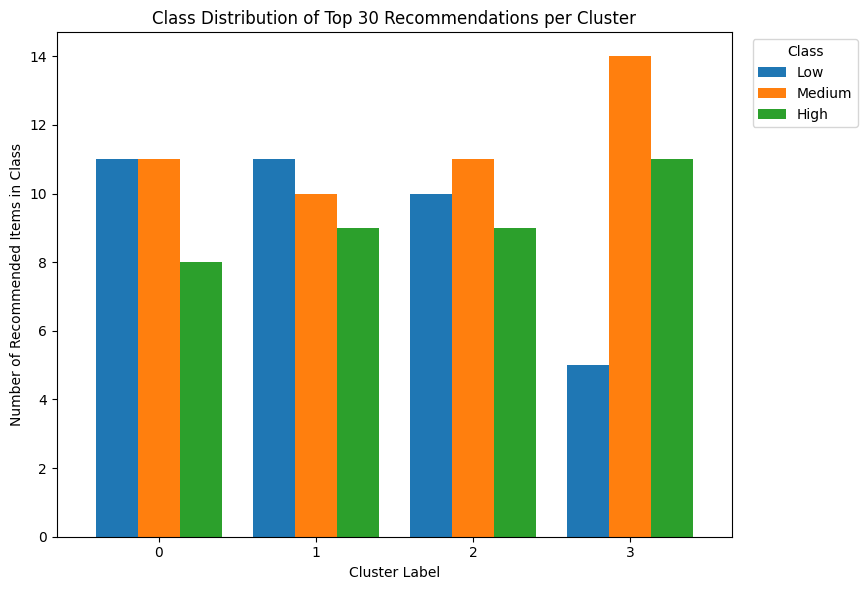


Class Proportion of Top Recommended Items per Cluster:


,Low,Medium,High
cluster_label,,,
0,0.366667,0.366667,0.266667
1,0.366667,0.333333,0.300000
2,0.333333,0.366667,0.300000
3,0.166667,0.466667,0.366667


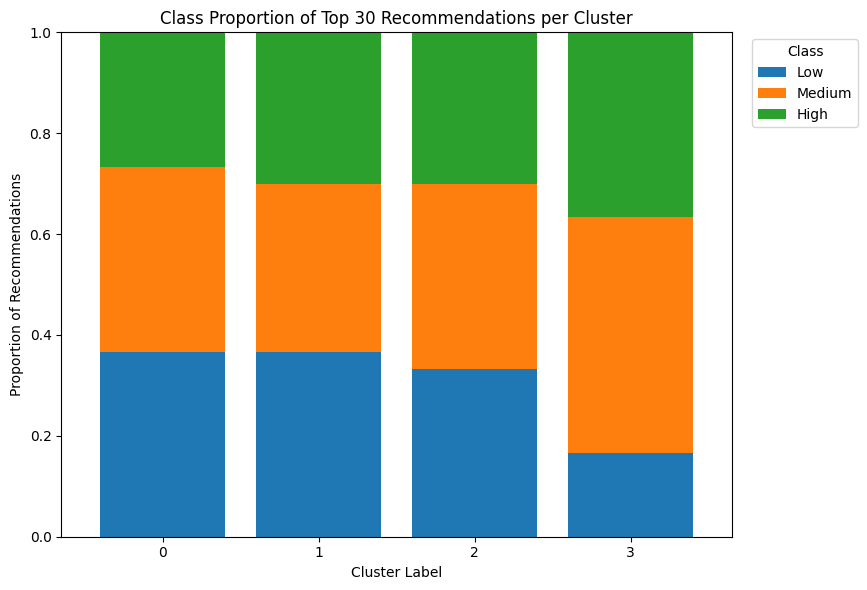

In [ ]:
# Get number of top recommendations per cluster
num_recommendations = len(top_items_per_cluster[0])

# Visualization: Grouped Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))
class_dist_df.plot(kind="bar", ax=ax, width=0.8)

ax.set_title(
    f"Class Distribution of Top {num_recommendations} Recommendations per Cluster"
)
ax.set_xlabel("Cluster Label")
ax.set_ylabel("Number of Recommended Items in Class")
ax.tick_params(axis="x", rotation=0)
ax.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

# Proportion of recommendations per class
class_prop_df = class_dist_df.apply(lambda x: x / x.sum(), axis=1).fillna(0)
print("\nClass Proportion of Top Recommended Items per Cluster:")
display(class_prop_df)

# Visualization: Stacked Bar Chart for Proportions
fig_prop, ax_prop = plt.subplots(figsize=(10, 6))
class_prop_df.plot(kind="bar", stacked=True, ax=ax_prop, width=0.8)

ax_prop.set_title(
    f"Class Proportion of Top {num_recommendations} Recommendations per Cluster"
)
ax_prop.set_xlabel("Cluster Label")
ax_prop.set_ylabel("Proportion of Recommendations")
ax_prop.tick_params(axis="x", rotation=0)
ax_prop.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left")
ax_prop.set_ylim(0, 1)
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()